In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import cmocean
from mpl_toolkits.basemap import Basemap

In [2]:
# import data
# we have data from two years in a monthly resolution and a grid with dimensions 1442x1021
data_2009 = pd.read_pickle('../data/2009_df.pkl')
data_2010 = pd.read_pickle('../data/2010_df.pkl')
data_2011 = pd.read_pickle('../data/2011_df.pkl')
data_2012 = pd.read_pickle('../data/2012_df.pkl')
data_2013 = pd.read_pickle('../data/2013_df.pkl')
data_2014 = pd.read_pickle('../data/2014_df.pkl')
data_2015 = pd.read_pickle('../data/2015_df.pkl')
data_2016 = pd.read_pickle('../data/2016_df.pkl')
data_2017 = pd.read_pickle('../data/2017_df.pkl')
data_2018 = pd.read_pickle('../data/2018_df.pkl')

In [3]:
data_2009 = data_2009[data_2009['tmask'] == 1]
data_2010 = data_2010[data_2010['tmask'] == 1]
data_2011 = data_2011[data_2011['tmask'] == 1]
data_2012 = data_2012[data_2012['tmask'] == 1]
data_2013 = data_2013[data_2013['tmask'] == 1]
data_2014 = data_2014[data_2014['tmask'] == 1]
data_2015 = data_2015[data_2015['tmask'] == 1]
data_2016 = data_2016[data_2016['tmask'] == 1]
data_2017 = data_2017[data_2017['tmask'] == 1]
data_2018 = data_2018[data_2018['tmask'] == 1]

data_2009['month'] = data_2009['time_counter'].apply(lambda x: x.month)
data_2009['year'] = 1

data_2010['month'] = data_2010['time_counter'].apply(lambda x: x.month)
data_2010['year'] = 2

data_2011['month'] = data_2011['time_counter'].apply(lambda x: x.month)
data_2011['year'] = 3

data_2012['month'] = data_2012['time_counter'].apply(lambda x: x.month)
data_2012['year'] = 4

data_2013['month'] = data_2013['time_counter'].apply(lambda x: x.month)
data_2013['year'] = 5

data_2014['month'] = data_2014['time_counter'].apply(lambda x: x.month)
data_2014['year'] = 6

data_2015['month'] = data_2015['time_counter'].apply(lambda x: x.month)
data_2015['year'] = 7

data_2016['month'] = data_2016['time_counter'].apply(lambda x: x.month)
data_2016['year'] = 8

data_2017['month'] = data_2017['time_counter'].apply(lambda x: x.month)
data_2017['year'] = 9

data_2018['month'] = data_2018['time_counter'].apply(lambda x: x.month)
data_2018['year'] = 10

In [4]:
data = pd.concat([data_2009,data_2010,data_2011,data_2012,data_2013,data_2014,data_2015,data_2016,data_2017], ignore_index=True)
data = data.sample(frac=1)
data.head()

,y,x,time_counter,nav_lat,nav_lon,time_centered,SST,tmask,e1t,e2t,...,stress_X,stress_Y,currents_X,currents_Y,fco2_pre,fco2,co2flux_pre,co2flux,month,year
13953389,258,1320,2010-06-16 00:00:00,-51.326035,42.750000,2010-06-16 00:00:00,2.495640,1,17371.716797,17371.716797,...,0.282377,-0.037731,0.085497,0.023452,289.301697,385.448578,-1.153172,-0.110126,6,2
8996389,713,957,2009-02-15 00:00:00,47.248817,-48.468906,2009-02-15 00:00:00,-0.178986,1,19193.384766,19091.050781,...,0.086861,0.006900,0.035917,-0.053058,233.852066,322.247314,4.031860,5.104576,2,1
16901103,455,479,2010-04-16 00:00:00,-10.687479,-167.500000,2010-04-16 00:00:00,29.833103,1,27317.498047,27317.498047,...,-0.040515,0.003776,0.001368,-0.008359,308.276642,395.716827,-0.765705,-0.503772,4,2
51762154,644,912,2013-11-16 00:00:00,34.163380,-59.286167,2013-11-16 00:00:00,23.548172,1,23012.214844,22561.775391,...,-0.004584,-0.038459,0.003051,0.084950,256.964600,348.742920,1.250129,2.333873,11,5
75376665,941,1201,2015-10-16 12:00:00,71.786911,44.113029,2015-10-16 12:00:00,5.437618,1,12893.765625,13399.110352,...,0.001670,0.031264,-0.008935,0.090400,227.559448,330.115906,2.782375,3.389721,10,7


In [5]:
month_to_predict = 9.0
feature_to_predict='fco2_pre'
training_data = data[:20000000]
test_data = data_2018

# reduce test data to specific month
test_data = test_data[test_data['month'] == month_to_predict]

training_target = training_data[feature_to_predict]
test_target = test_data[feature_to_predict]

training_input = training_data[['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month']]
test_input = test_data[['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month']]

X = training_input
Y = training_target

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [6]:
feature_names = ['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month']

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 8,
}

# Train with early stopping
evals = [(dtrain, "train"), (dval, "validation")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=50
)

[0]	train-rmse:28.51727	validation-rmse:28.53826
[50]	train-rmse:9.98044	validation-rmse:10.02619
[100]	train-rmse:8.42211	validation-rmse:8.47988
[150]	train-rmse:7.71352	validation-rmse:7.77871
[200]	train-rmse:7.26910	validation-rmse:7.33955
[250]	train-rmse:6.93837	validation-rmse:7.01391
[300]	train-rmse:6.70427	validation-rmse:6.78535
[350]	train-rmse:6.49782	validation-rmse:6.58290
[400]	train-rmse:6.33374	validation-rmse:6.42306
[450]	train-rmse:6.19757	validation-rmse:6.29005
[500]	train-rmse:6.06904	validation-rmse:6.16449
[550]	train-rmse:5.95955	validation-rmse:6.05868
[600]	train-rmse:5.86939	validation-rmse:5.97239
[650]	train-rmse:5.77759	validation-rmse:5.88337
[700]	train-rmse:5.70284	validation-rmse:5.81145
[750]	train-rmse:5.63882	validation-rmse:5.75066
[800]	train-rmse:5.57741	validation-rmse:5.69221
[850]	train-rmse:5.51950	validation-rmse:5.63687
[900]	train-rmse:5.45532	validation-rmse:5.57560
[950]	train-rmse:5.39824	validation-rmse:5.52183
[1000]	train-rmse:5.

Mean Squared Error (MSE): 23.46


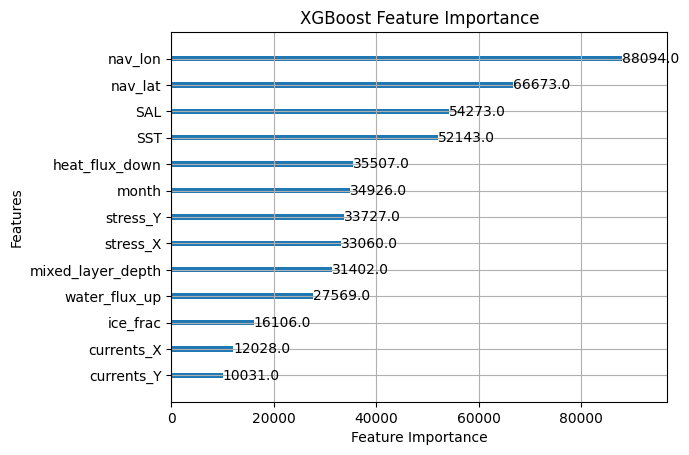

In [7]:
val = xgb.DMatrix(X_val)
y_pred = model.predict(val)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# Plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

In [8]:
test = xgb.DMatrix(test_input)

pred = model.predict(test)

# add prediction to data frame for displaying data
pred_reshaped = np.array(pred).reshape(-1)
test_results = test_data.assign(prediction=pd.Series(pred_reshaped).values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_results[feature_to_predict], test_results['prediction'])
print(f"Mean Squared Error (MSE): {mse:.2f}")


Mean Squared Error (MSE): 31.99


In [9]:
# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

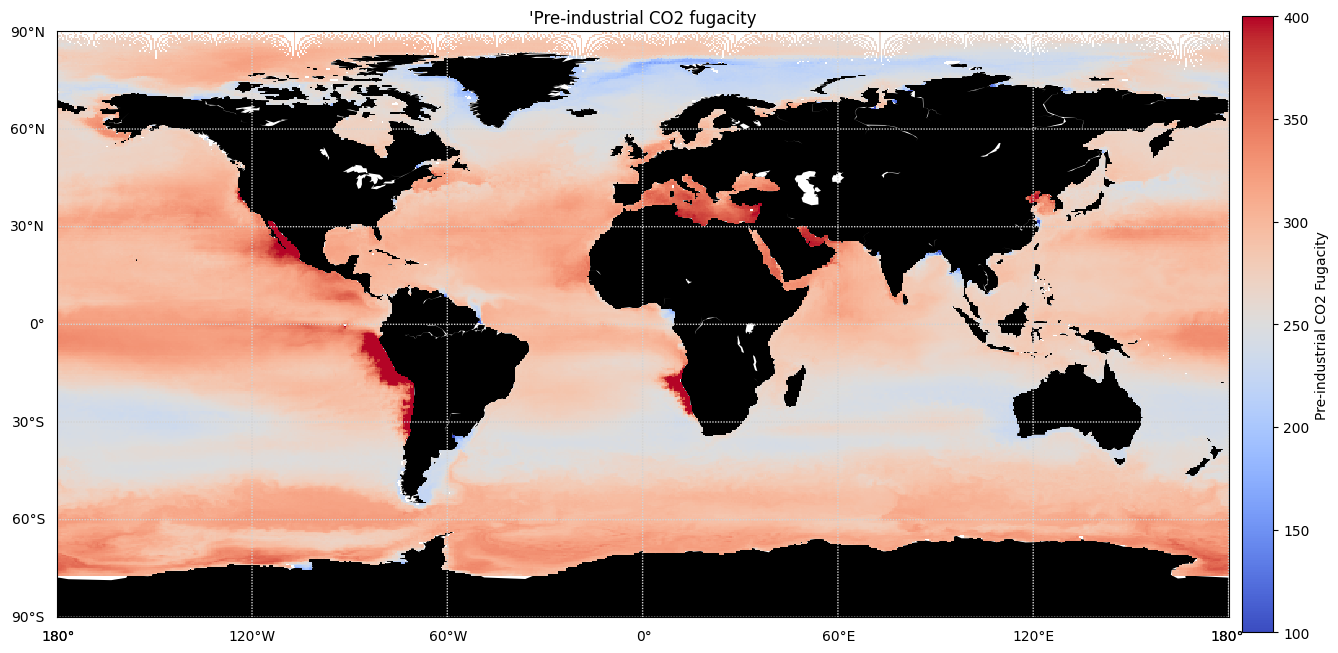

In [ ]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = row['prediction']

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='100', vmax='400', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

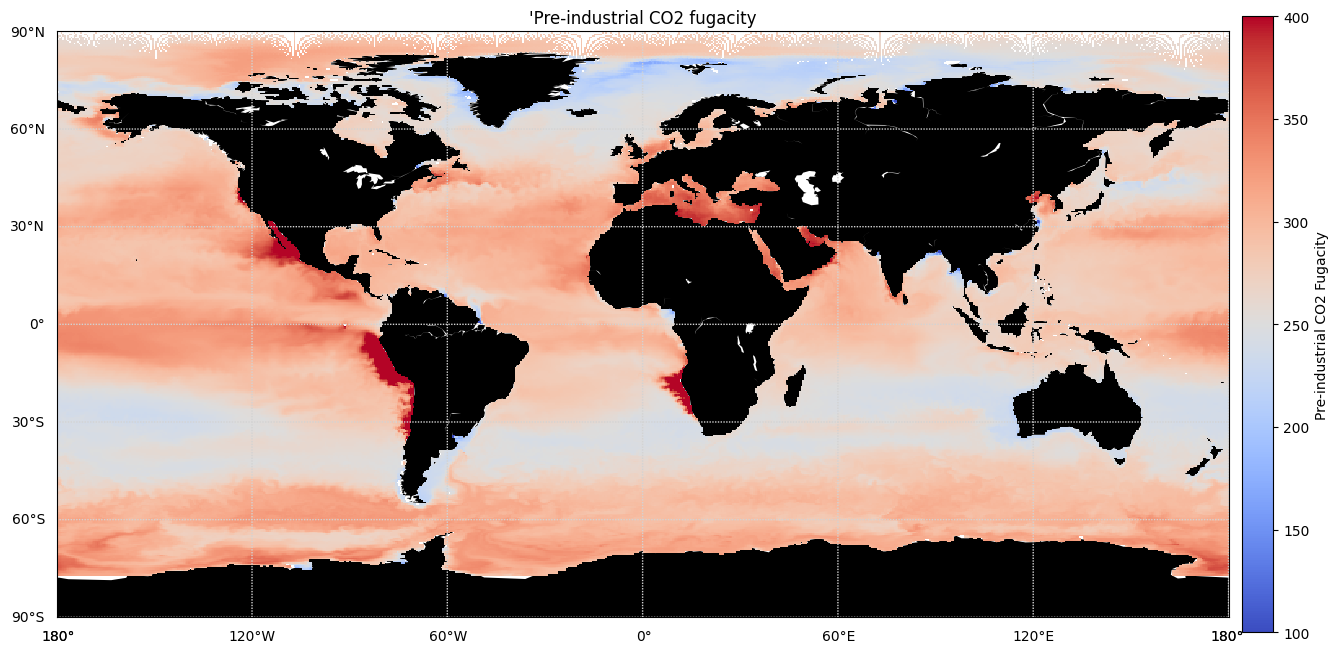

In [11]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = row[feature_to_predict]

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')
# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='100', vmax='400', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

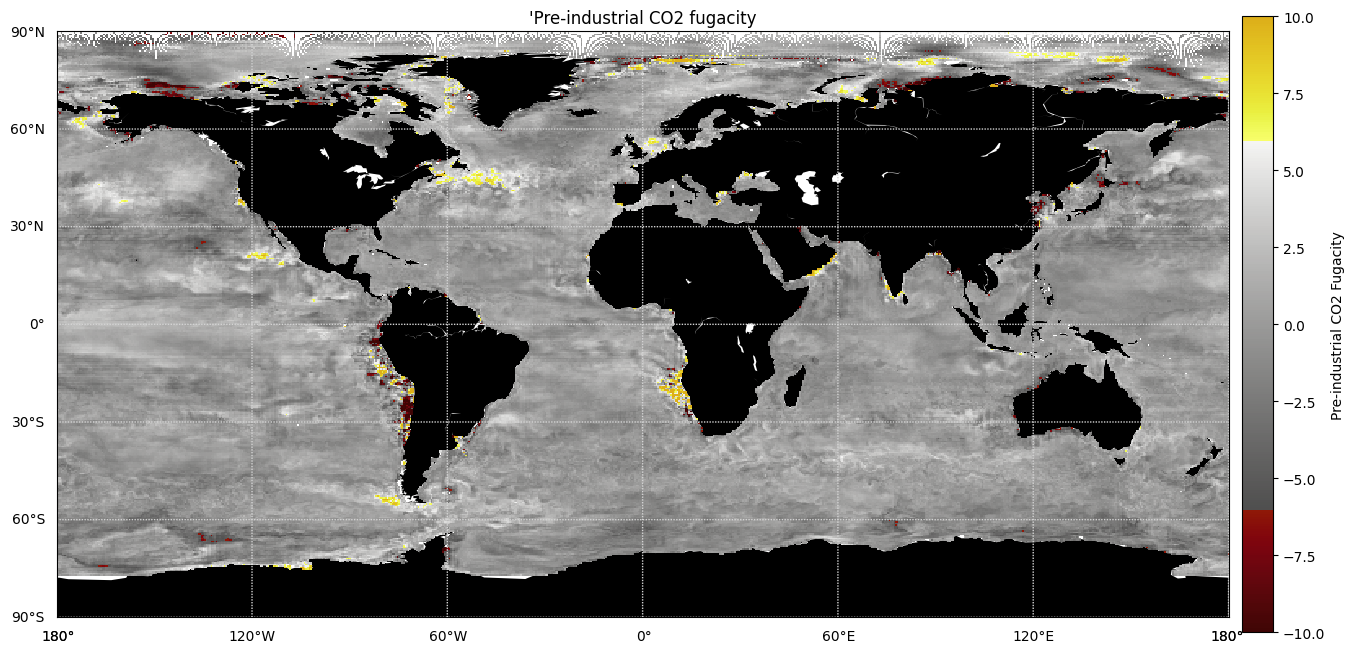

In [13]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_results.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = (row[feature_to_predict]-row['prediction'])/row[feature_to_predict]*100

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')
# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='-10', vmax='10', cmap=cmocean.cm.oxy, shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()